In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
def get_path_and_label(path):
  image_list = []
  label_list = []

  with open(path , 'r') as file:
    for line in file :
      text_list = line.split(' ')
      file_path = os.path.join('/home/Dataset',text_list[0])
      label = int(text_list[1])

      image_list.append(file_path)
      label_list.append(label)

  return image_list , label_list

In [3]:
import os
train_txt_path = '/home/Dataset/train.txt'
test_txt_path = '/home/Dataset/test.txt'
val_txt_path = '/home/Dataset/val.txt'

train_img , train_label = get_path_and_label(train_txt_path)
test_img , test_label = get_path_and_label(test_txt_path)
val_img , val_label = get_path_and_label(val_txt_path)

print(f"Len of train_img {len(train_img)} ")
print(f"Len of train_label {len(train_label)}")

print(f"Len of val_img {len(val_img)}")
print(f"Len of val_label {len(val_label)}")

print(f"Len of test_img {len(test_img)}")
print(f"Len of test_label {len(test_label)}")

Len of train_img 63325 
Len of train_label 63325
Len of val_img 450
Len of val_label 450
Len of test_img 450
Len of test_label 450


In [1]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms

[1718426244.717000] [a68ecfb3fe5e:1393961:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_path_list , img_label_list , transform=None, target_transform=None):
        self.img_path_list = img_path_list
        self.img_label_list  = img_label_list
        self.transform = transforms.Compose([transforms.Resize(size=((128,128)))])

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        image = read_image(self.img_path_list[idx])
        image = self.transform(image)
        if image.shape[0] == 1 :
          image = image.repeat(3,1,1)
        image = image.float() / 255.0
        label = self.img_label_list[idx]

        return image, label

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.conv = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(growth_rate)

    def forward(self, x):
        out = self.conv(x)
        out = F.relu(self.bn(out))
        out = torch.cat([x, out], 1)
        return out

class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(x)
        out = F.relu(self.bn(out))
        out = self.pool(out)
        return out

class DenseNet(nn.Module):
    def __init__(self, num_classes=50, growth_rate = 512, block_config=(1, 1), init_channels=512):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_channels = init_channels
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.features = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = self._make_dense_block(num_channels, num_layers)
            self.features.append(block)
            num_channels += num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_channels, num_channels // 2)
                self.features.append(trans)
                num_channels = num_channels // 2

        self.bn2 = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense_block(self, in_channels, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(Bottleneck(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.pool1(F.relu(self.bn1(out)))

        for layer in self.features:
            out = layer(out)

        out = F.relu(self.bn2(out))
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out
    
model = DenseNet(num_classes=50)
print(model)

DenseNet(
  (conv1): Conv2d(3, 512, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Transition(
      (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): Sequential(
      (0): Bottleneck(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=

In [4]:
from torchinfo import summary
batch_size = 1
summary(model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 50]                   --
├─Conv2d: 1-1                            [1, 512, 63, 63]          75,264
├─BatchNorm2d: 1-2                       [1, 512, 63, 63]          1,024
├─MaxPool2d: 1-3                         [1, 512, 32, 32]          --
├─ModuleList: 1-4                        --                        --
│    └─Sequential: 2-1                   [1, 1024, 32, 32]         --
│    │    └─Bottleneck: 3-1              [1, 1024, 32, 32]         2,360,320
│    └─Transition: 2-2                   [1, 512, 16, 16]          --
│    │    └─Conv2d: 3-2                  [1, 512, 32, 32]          524,288
│    │    └─BatchNorm2d: 3-3             [1, 512, 32, 32]          1,024
│    │    └─AvgPool2d: 3-4               [1, 512, 16, 16]          --
│    └─Sequential: 2-3                   [1, 1024, 16, 16]         --
│    │    └─Bottleneck: 3-5              [1, 1024, 16, 16]     

In [11]:
train_dataset = CustomImageDataset(train_img , train_label )
val_dataset = CustomImageDataset(val_img , val_label)
test_dataset = CustomImageDataset(test_img , test_label )

In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
import torch.optim as optim
model = DenseNet(num_classes=50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
#torch.cuda.empty_cache()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


cuda


In [15]:
def calculate_accuracy(output, labels):

    preds = torch.argmax(output, dim=1)

    correct = torch.eq(preds, labels).sum().item()

    total = preds.shape[0]

    return correct , total

  0%|          | 0/248 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


Epoch 0 training loss 0.013010692645380538 val loss 0.016645605829026962
Epoch 0 training accuracy 0.14086063955783656 val accuracy 0.12222222222222222


100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


Epoch 1 training loss 0.01079322115028041 val loss 0.014560316403706869
Epoch 1 training accuracy 0.2539281484405843 val accuracy 0.19777777777777777


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch 2 training loss 0.009239678938210929 val loss 0.012776052157084147
Epoch 2 training accuracy 0.34694038689301226 val accuracy 0.2688888888888889


100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch 3 training loss 0.007970505031822134 val loss 0.01437980122036404
Epoch 3 training accuracy 0.42488748519542047 val accuracy 0.23777777777777778


100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


Epoch 4 training loss 0.0069460108813870535 val loss 0.010145973629421658
Epoch 4 training accuracy 0.49020134228187917 val accuracy 0.34444444444444444


100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


Epoch 5 training loss 0.006102257806512145 val loss 0.010621052847968207
Epoch 5 training accuracy 0.5479510461902882 val accuracy 0.37777777777777777


100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Epoch 6 training loss 0.005400286869149974 val loss 0.010499583880106607
Epoch 6 training accuracy 0.5988945913936045 val accuracy 0.3977777777777778


100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


Epoch 7 training loss 0.004811237331816579 val loss 0.008748472531636556
Epoch 7 training accuracy 0.6384208448480063 val accuracy 0.4777777777777778


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Epoch 8 training loss 0.00423475144458203 val loss 0.00817821635140313
Epoch 8 training accuracy 0.6770627714172918 val accuracy 0.46


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Epoch 9 training loss 0.0037203114380066544 val loss 0.007301978535122341
Epoch 9 training accuracy 0.7160994867745756 val accuracy 0.5244444444444445


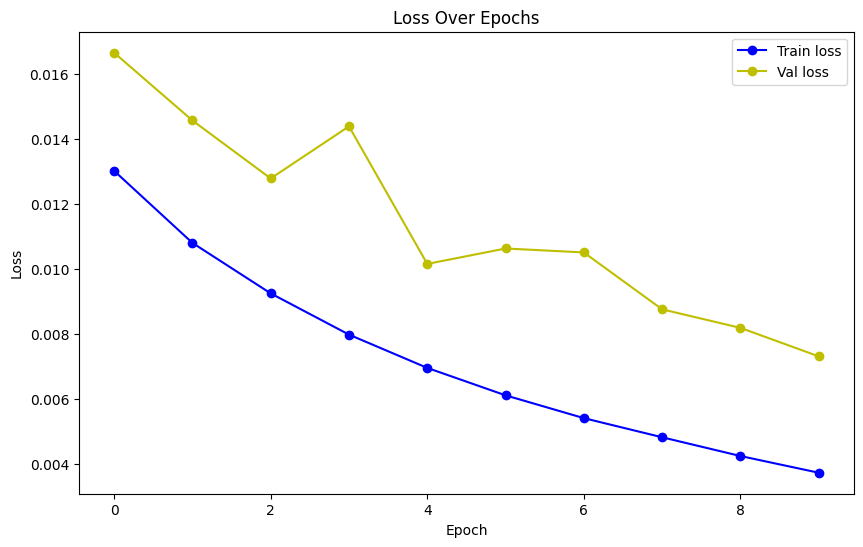

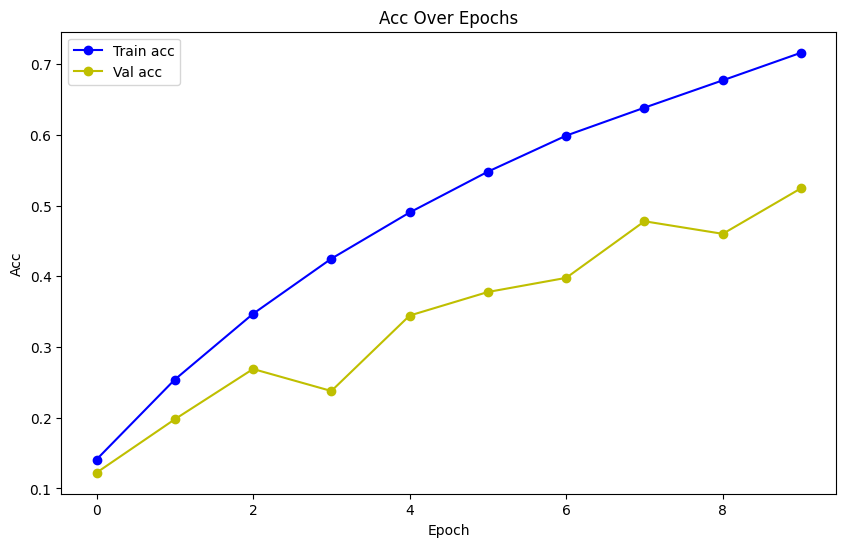

In [16]:
from tqdm import tqdm
import matplotlib.pyplot as plt
#dropout = 0.1
EPOCH = 10
training_loss_list = []
val_loss_list = []
training_accuracy_list = []
val_accuracy_list = []

for epoch in range(EPOCH) :
  training_loss = 0.0
  training_total_num = 0
  training_correct_num = 0
  val_loss = 0.0
  val_total_num = 0
  val_correct_num = 0
  model.train()
  for data in tqdm(train_dataloader) :
    img , label = data
    #print(img.shape)
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    outputs = model(img)
    #print(outputs.shape)
    #print(outputs[0])
    #print(label[0])
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    training_correct_num += correct_num
    training_total_num += count

  model.eval()
  for data in tqdm(val_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)
    val_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    val_correct_num += correct_num
    val_total_num += count

  training_loss = training_loss/training_total_num
  val_loss = val_loss/val_total_num
  training_accuracy = training_correct_num/training_total_num
  val_accuracy = val_correct_num/val_total_num
  print(f"Epoch {epoch} training loss {training_loss} val loss {val_loss}")
  print(f"Epoch {epoch} training accuracy {training_accuracy} val accuracy {val_accuracy}")
  training_loss_list.append(training_loss)
  training_accuracy_list.append(training_accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(training_loss_list, marker='o', linestyle='-', color='b' , label = 'Train loss')
plt.plot(val_loss_list, marker='o', linestyle='-', color='y', label = 'Val loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy_list, marker='o', linestyle='-', color='b' , label = 'Train acc')
plt.plot(val_accuracy_list, marker='o', linestyle='-', color='y', label = 'Val acc')
plt.title('Acc Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [18]:
test_loss = 0.0
test_correct_num = 0
test_total_num = 0
model.eval()
for data in tqdm(test_dataloader) :
  img , label = data
  img = img.to(device)
  label = label.to(device)
  optimizer.zero_grad()

  outputs = model(img)
  #print(outputs[0])
  loss = criterion(outputs, label)
  #loss.backward()
  #optimizer.step()
  test_loss += loss.item()
  correct_num , count  = calculate_accuracy(outputs,label)
  test_correct_num += correct_num
  test_total_num += count

test_loss = test_loss/test_total_num
test_accuracy = test_correct_num/test_total_num
print(f"Test loss {test_loss} test accuracy {test_accuracy}")

100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

Test loss 0.007738926940494113 test accuracy 0.5377777777777778
